Test ground filtering on full range

In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep


home = os.path.join(os.path.expanduser('~'), "buni")

dataset_path = Path(os.path.join(home, "dataset", "av2", "train"))

av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

scene_idx = 0
frame_idx = 0

scene_id = av2.get_log_ids()[scene_idx]
frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)

points = Sweep.from_feather(frame_path).xyz

In [3]:
from ground_estimator.ground_estimator import remove_ground

_, non_ground, _ = remove_ground(points, points, percentile=30)

Applying DBSCAN clustering.
DBSCAN clustering completed.
Estimating ground height.
Performing first round of RANSAC for ground plane fitting.
First round of RANSAC completed.
Performing second round of RANSAC for refined ground plane fitting.
Final ground points identified.
Ground removal process completed.


In [4]:
from bboxer_av2.bboxer import *

bbox_estimator = Bboxer()
bbox_estimator.cluster(points=non_ground[:,:2])

In [5]:
rects_modest = bbox_estimator.estimate_bboxes_from_clusters_modest(
    bbox_estimator.clustered_points,
    bbox_estimator.clustered_labels,
    fit_method='closeness_to_edge'
)

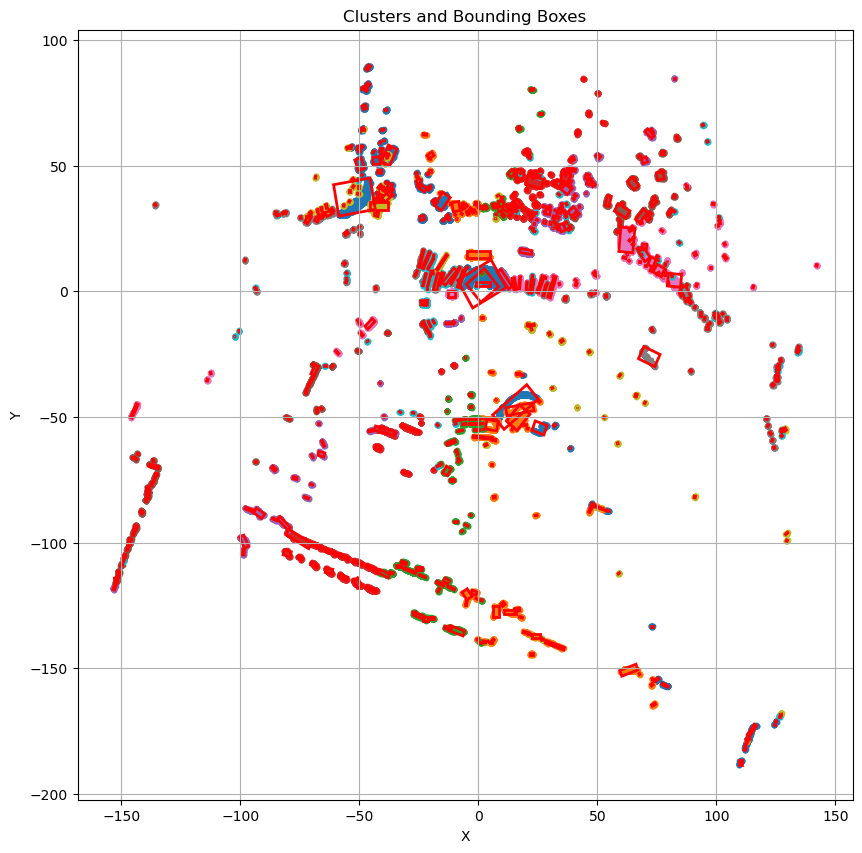

In [6]:
from bboxer_av2 import utils as box_utils

box_utils.visualize_bboxes_for_modest_fitting(
    bbox_estimator.clustered_points,
    bbox_estimator.clustered_labels,
    rects_modest
)

In [7]:
from shapely.geometry import Polygon
from typing import List, Tuple

def convert_format(boxes_array: np.ndarray) -> Tuple[np.ndarray, List[int]]:
    # boxes_array is a numpy array of shape (N, 4, 2)
    polygons = []
    err_idxs = []
    for idx, box in enumerate(boxes_array):
        try: 
            polygon = Polygon([(point[0], point[1]) for point in box] + [(box[0, 0], box[0, 1])])
            polygons.append(polygon)
        except Exception as e:
            print(f"Error converting bbox at index {idx}: {e}")
            err_idxs.append(idx)
                            
    return np.array(polygons), err_idxs

def compute_iou(box: Polygon, boxes: List[Polygon]):
    """Calculates IoU of the given box with the array of the given boxes.
    Note: the areas are passed in rather than calculated here for efficiency. 
    Calculate once in the caller to avoid duplicate work.
    
    Args:
        box: a polygon (shapely.geometry.Polygon)
        boxes: a numpy array of shape (N,), where each member is a shapely.geometry.Polygon
    Returns:
        a numpy array of shape (N,) containing IoU values
    """
    iou_lst = []
    for b in boxes:
        intersection = box.intersection(b).area
        union = box.union(b).area
        iou = intersection / union if union > 0 else 0
        iou_lst.append(iou)
    return np.array(iou_lst, dtype=np.float32)

def non_max_suppression(boxes: np.ndarray, scores: np.ndarray, threshold):
    """Performs non-maximum suppression and returns indices of kept boxes.
    
    Args:
        boxes: numpy array of shape (N, 4, 2)
        scores: numpy array of shape (N,)    
    
    boxes: [N, (y1, x1, y2, x2)]. Notice that (y2, x2) lays outside the box.
    scores: 1-D array of box scores.
    threshold: Float. IoU threshold to use for filtering.

    return an numpy array of the positions of picks
    """
    assert boxes.shape[0] > 0
    if boxes.dtype.kind != "f":
        boxes = boxes.astype(np.float32)

    polygons, err_idexes = convert_format(boxes)

    top = 64
    # Get indicies of boxes sorted by scores (highest first)
    ixs = scores.argsort()[::-1][:64]

    pick = []
    while len(ixs) > 0:
        # Pick top box and add its index to the list
        i = ixs[0]
        pick.append(i)
        # Compute IoU of the picked box with the rest
        iou = compute_iou(polygons[i], polygons[ixs[1:]])
        # Identify boxes with IoU over the threshold. This
        # returns indices into ixs[1:], so add 1 to get
        # indices into ixs.
        remove_ixs = np.where(iou > threshold)[0] + 1
        # Remove indices of the picked and overlapped boxes.
        ixs = np.delete(ixs, remove_ixs)
        ixs = np.delete(ixs, 0)

    return np.array(pick, dtype=np.int32)


def filter_pred(corners, nms_iou_threshold) -> Tuple[np.ndarray, np.ndarray]:
    """
    Shape of pred is [N, 4, 2]
    
    Args: 
        pred: a numpy array of shape (N, 4, 2)
    Returns:
        corners: a numpy array of shape (N, 4, 2)
        scores: a numpy array of shape (N,)
    """
    scores = np.ones(corners.shape[0])
    selected_ids = non_max_suppression(corners, scores, nms_iou_threshold)
    corners = corners[selected_ids]
    scores = scores[selected_ids]
    return corners, scores

def process_rects_modest_to_corners(lst_dict: List[Dict]):
        """
        Get the corners of the all bboxes in a frame in the format (N, 4, 2) where N is the number of bboxes
        """
        corners_list = []
        for d in lst_dict:
            corners = get_corners([d['box_center'][0],d['box_center'][1], d['box_length'], d['box_width'], d['ry']])
            corners_list.append(corners)
    
        corners_array = np.array(corners_list)    
        return corners_array
    
    
def get_corners(bbox: List[float]) -> np.ndarray:
        """
        return the 4 corners of the bounding box in the bird's eye view
        
        Args:
            bbox:  list of the bounding box parameters of shape (5)
        
        Returns:
            bev_corners: [4 * 2] numpy array of the 4 corners' (x, y) coordinates in the bird's eye view
            
        The order of points returned is clockwise
        (quadrant 3 -> quadrant 2 -> quadrant 1 -> quadrant 4)
        """
        x, y, l, w, yaw = bbox
        
        bev_corners = np.zeros((4, 2), dtype=np.float32)
        # rear left
        bev_corners[0, 0] = x - l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[0, 1] = y - l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        # rear right
        bev_corners[1, 0] = x - l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[1, 1] = y - l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front right
        bev_corners[2, 0] = x + l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[2, 1] = y + l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front left
        bev_corners[3, 0] = x + l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[3, 1] = y + l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        return bev_corners
                

In [8]:
rects_corners = process_rects_modest_to_corners(rects_modest)

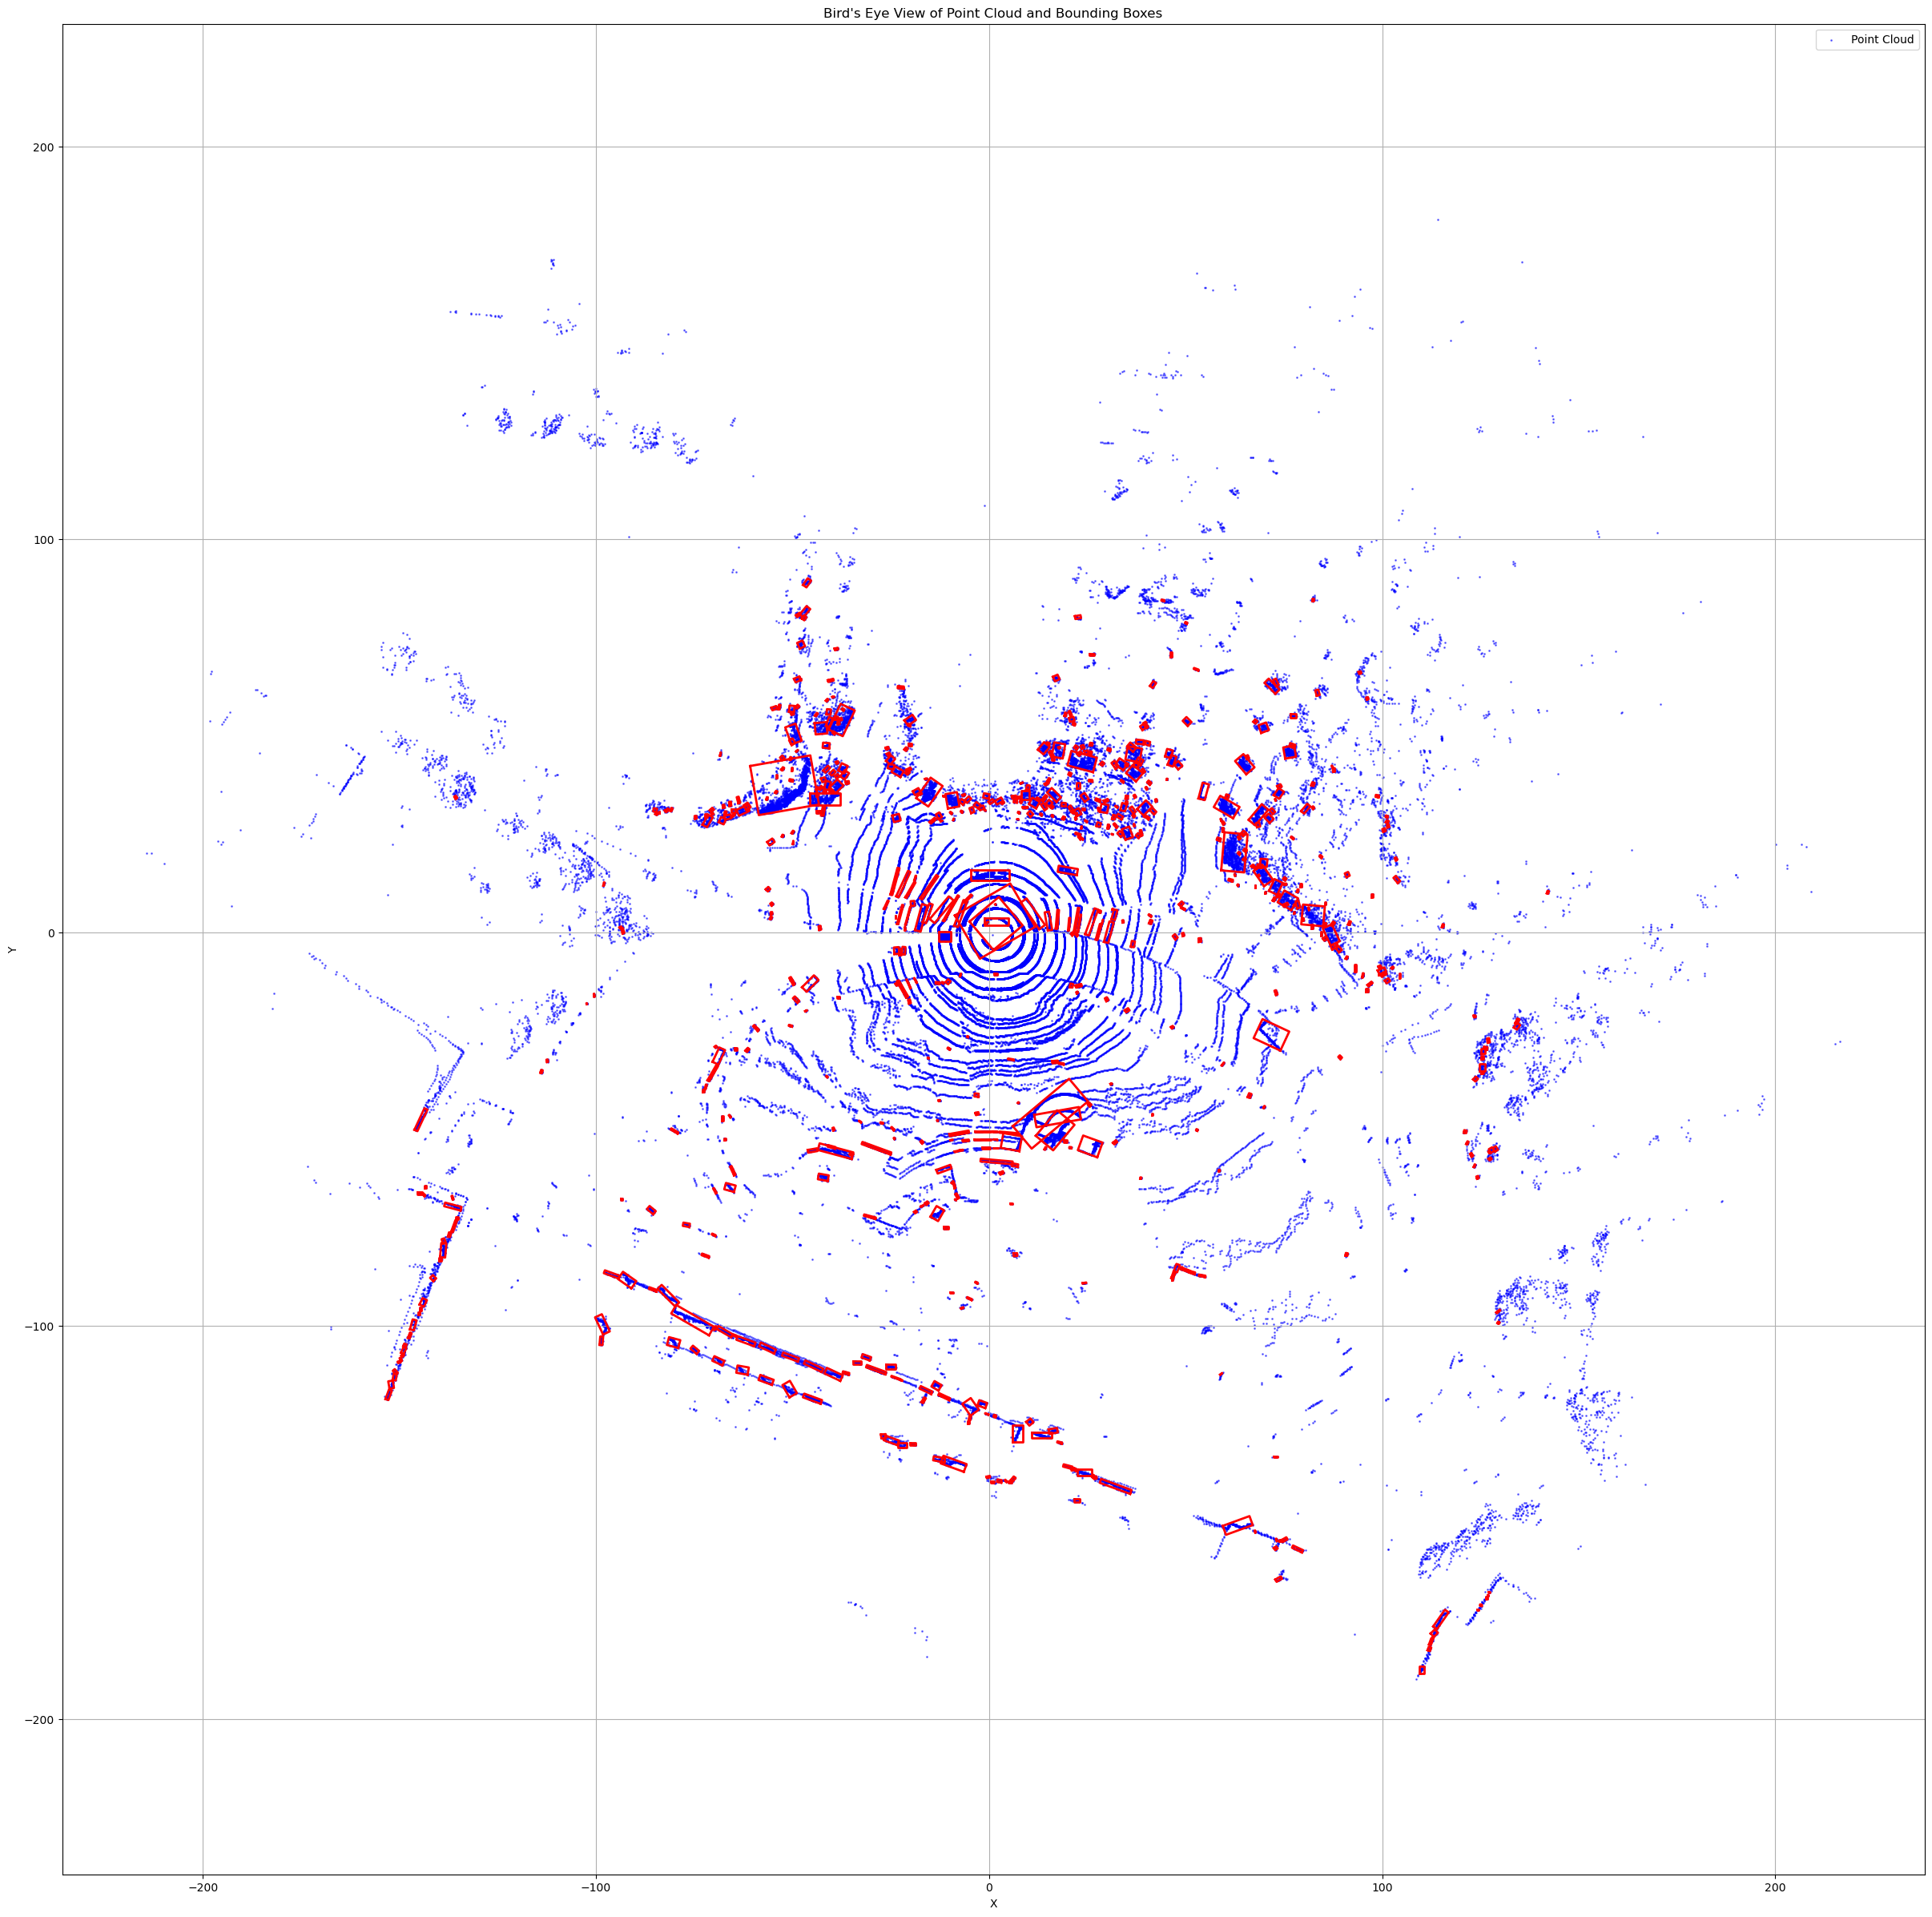

In [12]:
from prototype_utils import plot_point_cloud_and_bboxes

plot_point_cloud_and_bboxes(points[:,:2], rects_corners, fig_size=(30,30))

In [9]:
refined_rects, _ = filter_pred(rects_corners, 0.5)

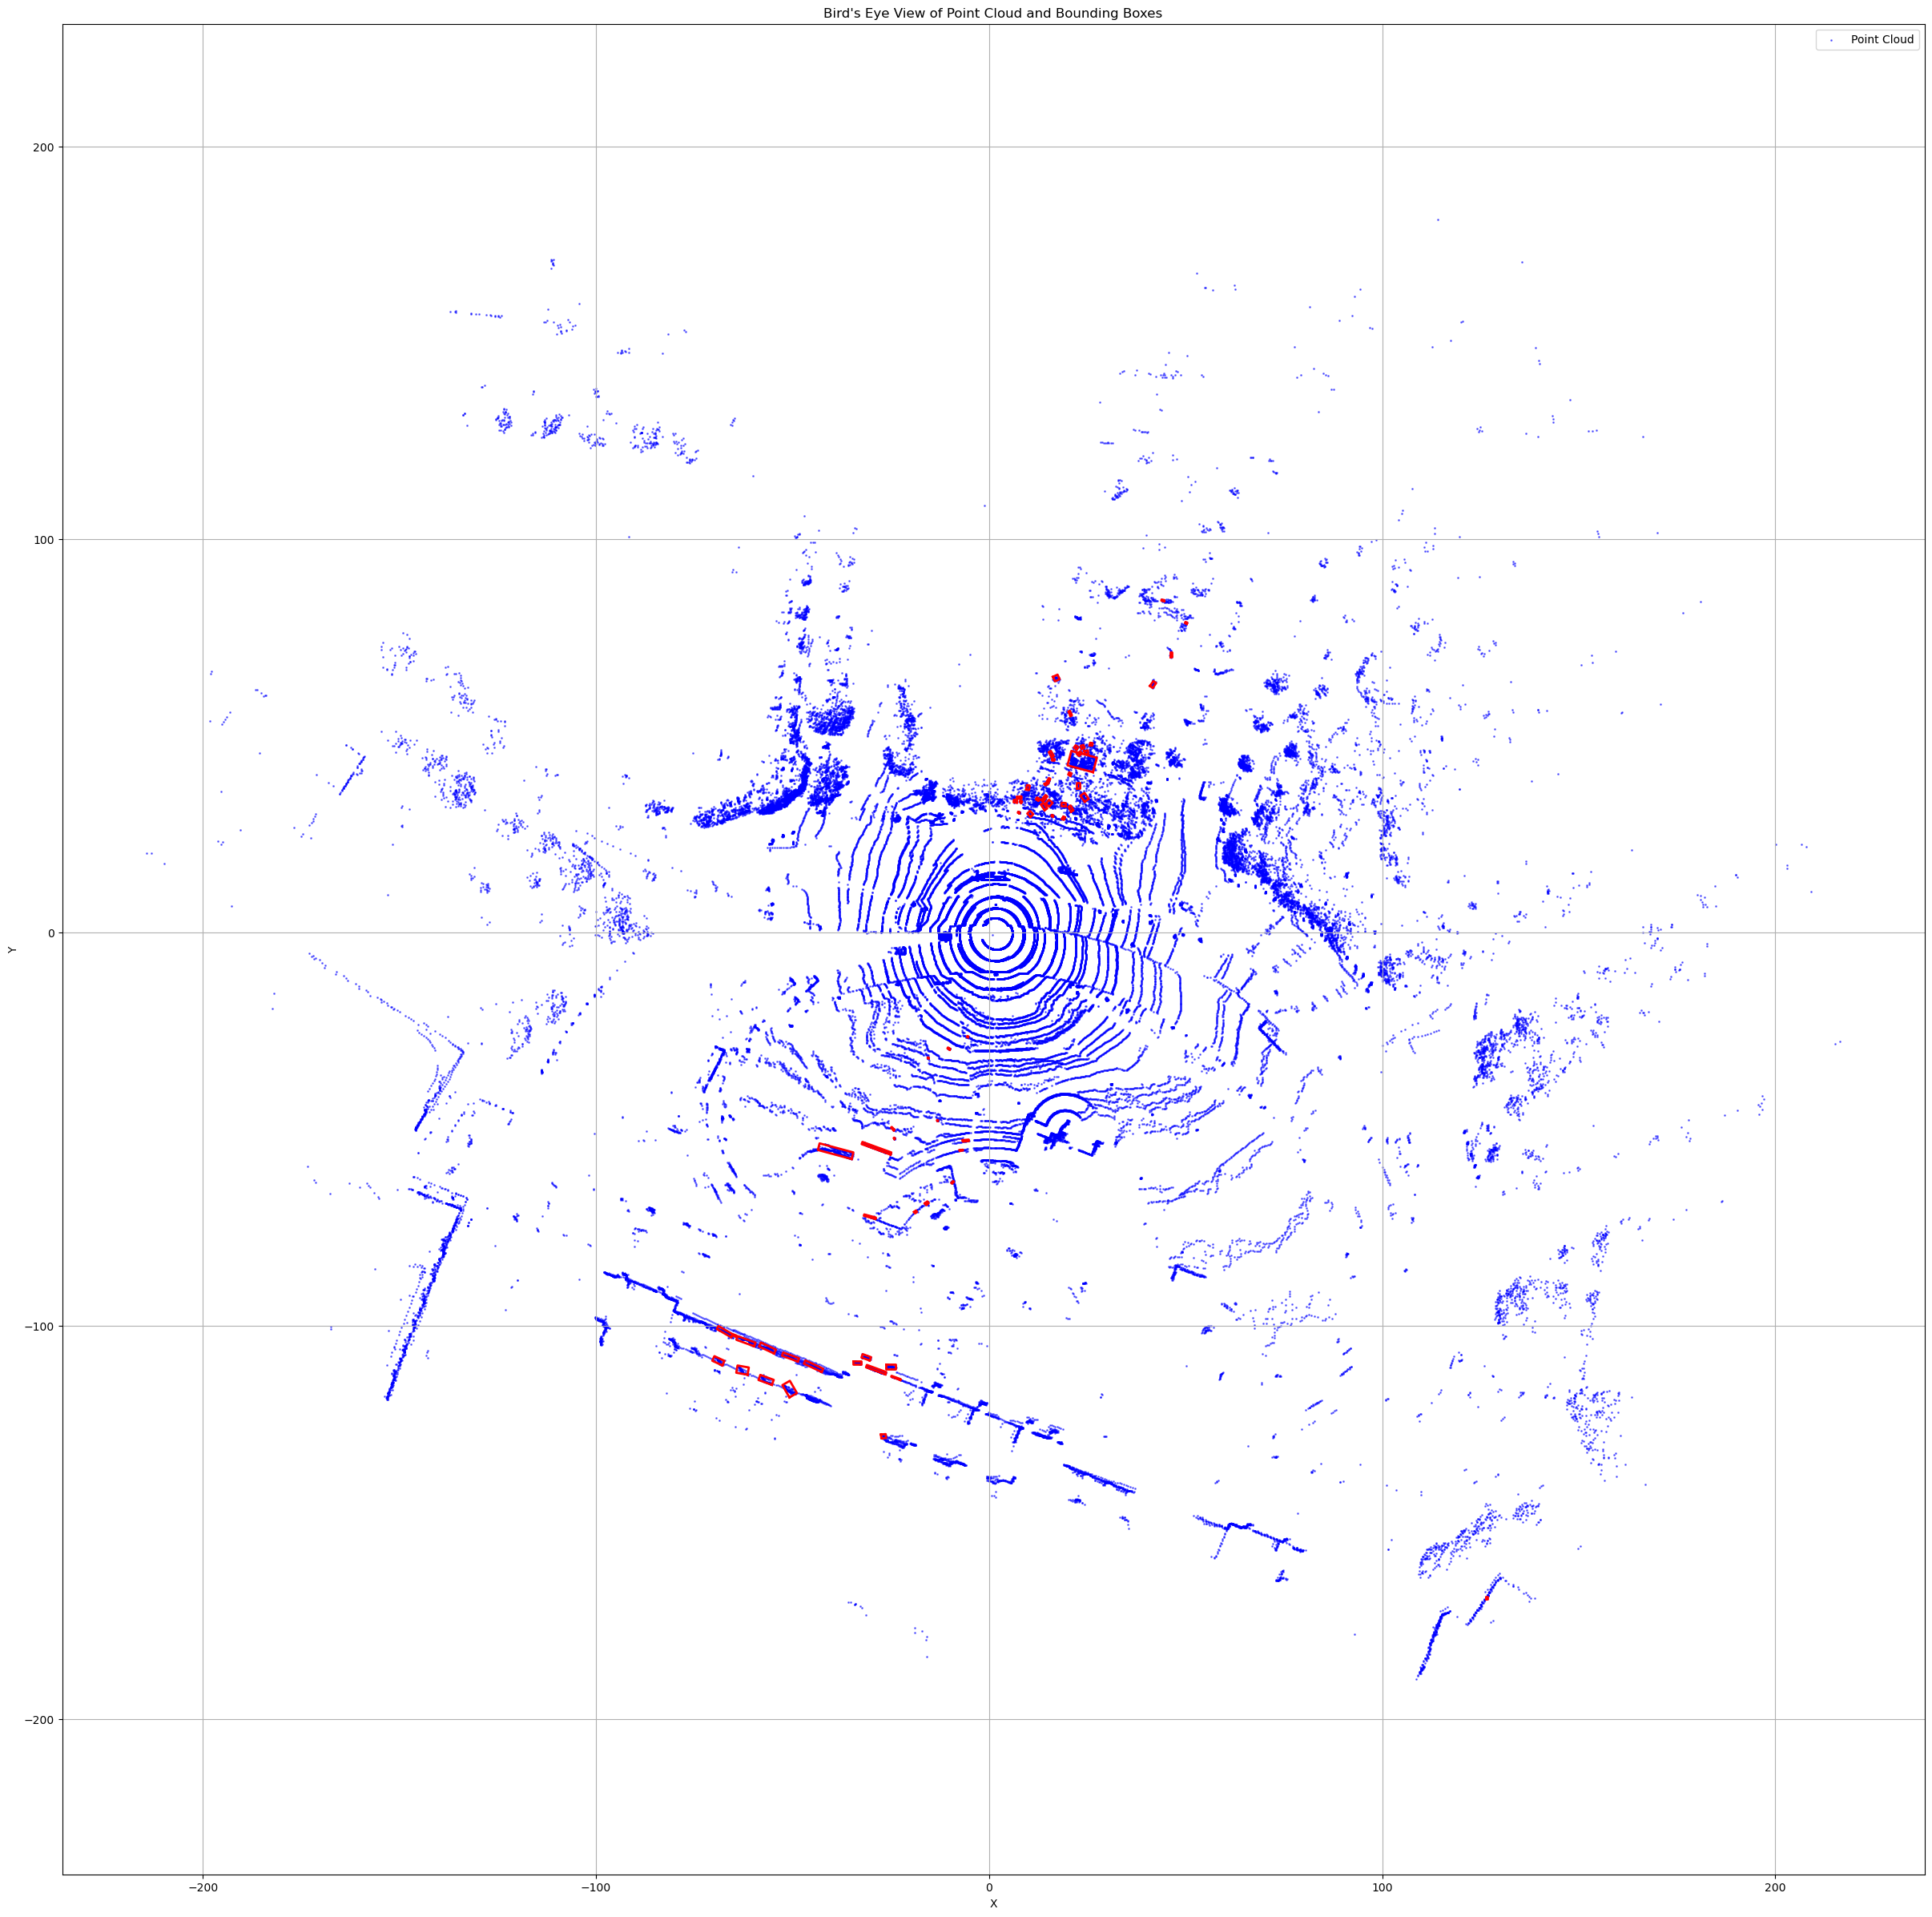

In [13]:
from prototype_utils import plot_point_cloud_and_bboxes

plot_point_cloud_and_bboxes(points[:,:2], refined_rects, fig_size=(30,30))